In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('0711_Landata.csv')

data = data.sort_values(by=['Rank'])

data.head()

,Unnamed: 0,Rank,都市土地使用分區_空值,一般農業區,住,其他,商,山坡地保育區,工,工業區,...,露台,通道,車庫,陽台,屋頂突出物,儲藏室,車位總價,lat,lng,總價元
8506,8506,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.061855,0.634850,1805275500
33654,33654,2,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.008934,0.485005,1450000000
54521,54521,3,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.088486,0.441842,1380000000
10655,10655,4,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,0.000000,0.000000,1112000000
47147,47147,5,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.058463,0.465010,1050000000


rank前1000做traing, 500做validation

In [2]:
data_1000 = data[:1000]
val_500 = data[1000:1500]

In [3]:
train_x = data_1000.drop(['Unnamed: 0', 'Rank', '總價元'], axis=1).reset_index(drop=True)
train_y = data_1000['Rank'].copy().reset_index(drop=True)
test_x = val_500.drop(['Unnamed: 0', 'Rank', '總價元'], axis=1).reset_index(drop=True)
test_y = val_500['Rank'].copy().reset_index(drop=True)

In [4]:
import itertools
index = np.array(list(itertools.permutations(np.arange(1000), 2)))
index_test = np.array(list(itertools.permutations(np.arange(500), 2)))
np.random.shuffle(index)
np.random.shuffle(index_test)

In [14]:
sample_size = 100000
selected = np.random.choice(index.shape[0], sample_size)
select_test = np.random.choice(index_test.shape[0], sample_size)
index = index[selected]
index_test = index_test[select_test]

In [15]:
def target(I, J):
    target = np.subtract(I, J) 
    # sign => 大於 0為1, clip => 限制在0, 1
    target = np.clip(np.sign(target), 0, 1)
    return target

target_train = target(train_y.iloc[index[:,0]], train_y.iloc[index[:,1]])
target_test = target(test_y.iloc[index_test[:,0]], test_y.iloc[index_test[:,1]])

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Subtract, Activation, Input
import keras.optimizers

feature_num = train_x.shape[1]
marker = Sequential()
marker.add(Dense(256, activation='relu', input_shape=(feature_num,)))
marker.add(Dense(128, activation='relu'))
marker.add(Dense(64, activation='relu'))
marker.add(Dense(1, activation='linear'))

i_input = Input(shape=(feature_num,))
j_input = Input(shape=(feature_num,))
i_score = marker(i_input)
j_score = marker(j_input)

diff = Subtract()([i_score, j_score])
output = Activation('sigmoid')(diff)

ranknet = Model([i_input, j_input], output)
optimizer = keras.optimizers.Adam(lr=1e-3, decay=0.0)
ranknet.summary()
ranknet.compile(optimizer = optimizer, loss = "binary_crossentropy",metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 119)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 119)          0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            71937       input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 1)            0           sequential_2[1][0]               
          

Train on 100000 samples, validate on 100000 samples
Epoch 1/10
 - 2s - loss: 0.3268 - acc: 0.8495 - val_loss: 1.2296 - val_acc: 0.5449
Epoch 2/10
 - 2s - loss: 0.1783 - acc: 0.9258 - val_loss: 1.6389 - val_acc: 0.5376
Epoch 3/10
 - 2s - loss: 0.1399 - acc: 0.9422 - val_loss: 1.8423 - val_acc: 0.5632
Epoch 4/10
 - 2s - loss: 0.1236 - acc: 0.9499 - val_loss: 2.0843 - val_acc: 0.5470
Epoch 5/10
 - 2s - loss: 0.1096 - acc: 0.9555 - val_loss: 2.2362 - val_acc: 0.5603
Epoch 6/10
 - 2s - loss: 0.0996 - acc: 0.9602 - val_loss: 2.3974 - val_acc: 0.5497
Epoch 7/10
 - 2s - loss: 0.0908 - acc: 0.9640 - val_loss: 2.5430 - val_acc: 0.5472
Epoch 8/10
 - 2s - loss: 0.0885 - acc: 0.9654 - val_loss: 2.5899 - val_acc: 0.5385
Epoch 9/10
 - 2s - loss: 0.0812 - acc: 0.9687 - val_loss: 2.8542 - val_acc: 0.5497
Epoch 10/10
 - 2s - loss: 0.0800 - acc: 0.9690 - val_loss: 2.8172 - val_acc: 0.5509


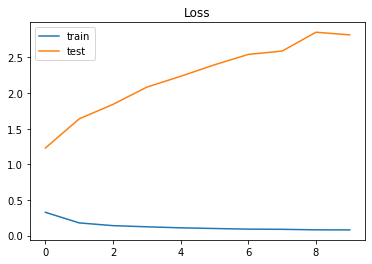

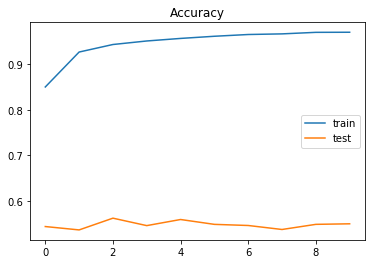

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
EPOCHS = 10
BATCH_SIZE = 300
model_history = ranknet.fit([train_x.iloc[index[:,0]], train_x.iloc[index[:,1]]], target_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=([test_x.iloc[index_test[:,0]], test_x.iloc[index_test[:,1]]], target_test), verbose=2)

plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(model_history.history['acc'], label='train')
plt.plot(model_history.history['val_acc'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

> https://stackoverflow.com/questions/41430791/python-list-error-1-step-on-1-slice

In [18]:
score = marker.predict([test_x])

# ::-1表示由大排到小
Top_10 = test_y.iloc[np.argsort(score, axis=0)[::-1][:10, 0]]

Rec = len(Top_10 & test_y[:10])
print('Rec：%d' % (Rec))

Rec：19


In [19]:
Top_10

266    1267
322    1323
455    1456
148    1149
468    1469
212    1213
338    1339
52     1053
8      1009
209    1210
Name: Rank, dtype: int64

In [20]:
# 正解
test_y[:10]

0    1001
1    1002
2    1003
3    1004
4    1005
5    1006
6    1007
7    1008
8    1009
9    1010
Name: Rank, dtype: int64